In [9]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from pandas import set_option
# set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None



##### import stuff from scikit learn
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

filename = 'data/facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data.head()
print (training_data.shape)

(4149, 11)


In [2]:
training_data.dropna(inplace=True)
print (training_data.shape)

(3232, 11)


In [3]:
###### create predictor and target arrays
X = training_data.iloc[:, 4:]
y = training_data['Facies']
groups = training_data['Well Name']

In [4]:
from matplotlib.colors import Normalize


class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [5]:
C_range = 10.0 ** np.arange(0, 10)
gamma_range= 10.0 ** np.arange(-10, 0)
param_grid = dict(svc__C=C_range, svc__gamma=gamma_range)
SVM = make_pipeline(StandardScaler(), SVC())
cv=LeaveOneGroupOut()#.split(X, y, groups)
# scoring options: ['accuracy', 'adjusted_rand_score', 'average_precision', 'f1', 'log_loss', 'mean_squared_error', 'precision', 'r2', 'recall', 'roc_auc'] 

print("# Tuning hyper-parameters for f1_score")
print("Best parameters set found on development set:")
grid = GridSearchCV(SVM, param_grid, cv=cv, scoring='f1_weighted')
#clf = grid.get_params()
clf = grid.fit(X, y, groups=groups)
print(clf.cv_results_['params'][clf.best_index_])
print("Score: %0.03f" % clf.best_score_)
print("")
#for params, mean_score, scores in clf.grid_scores_:
        #print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() * 2, params))
# Do a graphic representation
scores = [x[1] for x in clf.grid_scores_]
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

# Tuning hyper-parameters for f1_score
Best parameters set found on development set:
{'svc__C': 100000000.0, 'svc__gamma': 1.0000000000000001e-05}
Score: 0.509



C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Heat map:


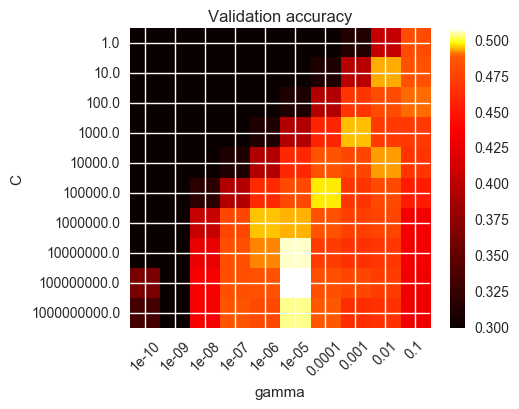

In [8]:
print('Heat map:')
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.3, right=0.8, bottom=0.3, top=0.8)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot, norm=MidpointNormalize(vmin=0.3, midpoint=0.49))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

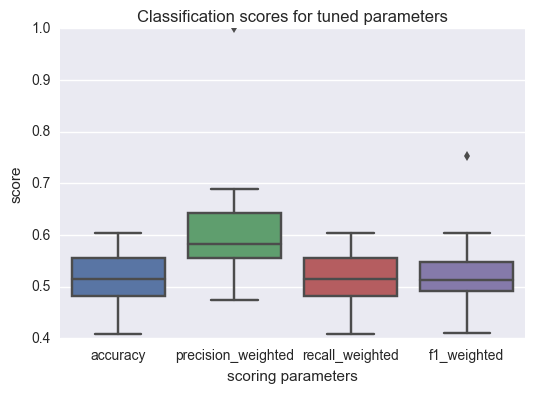

In [10]:
######### Estimation of final scores from this tuning:
scoring_param = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted' ]
scores = []

for scoring in scoring_param:
    SVM = make_pipeline(StandardScaler(), SVC(C=10000000, gamma=1e-5))
    cv=LeaveOneGroupOut().split(X, y, groups)
    validated = cross_val_score(SVM, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=scoring_param)
    
sns.boxplot(data=scores)

plt.xlabel('scoring parameters')
plt.ylabel('score')
plt.title('Classification scores for tuned parameters')
plt.show()